# Phase 1: Text Preprocessing and Exploratory Data Analysis

## Project Overview

This notebook implements **Phase 1** of the YouTube Video Summarization project, focusing on:

- **Text Preprocessing**: Comprehensive data cleaning and normalization
- **Exploratory Data Analysis (EDA)**: Dataset statistics and visualizations
- **Word Representations**: TF-IDF and BERT embeddings
- **Embedding Visualization**: PCA and t-SNE dimensionality reduction

## Objectives

1. Perform thorough text preprocessing (tokenization, lowercasing, stopword removal, lemmatization, punctuation cleaning)
2. Explore and analyze the CNN/DailyMail summarization dataset
3. Apply suitable word representation methods (TF-IDF and BERT)
4. Visualize embeddings using PCA and t-SNE

## Dataset

We use the **CNN/DailyMail** dataset - a large-scale summarization dataset that aligns with our YouTube video summarization goals, as both involve extracting key information from longer text sources.

---


## 1. Setup and Dependencies

First, we'll install all required libraries for Google Colab environment.


In [1]:
# Install required packages
!pip install -q datasets transformers torch
!pip install -q scikit-learn matplotlib seaborn plotly wordcloud
!pip install -q nltk spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.6/221.6 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.3/377.3 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.2/539.2 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 84.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to 

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy
import re
from collections import Counter
from wordcloud import WordCloud

# ML Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Transformers
from transformers import BertTokenizer, BertModel
import torch

# Datasets
from datasets import load_dataset

# Utilities
from tqdm.auto import tqdm
import time

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


All libraries imported successfully!


## 2. Dataset Loading

We'll load the CNN/DailyMail dataset from Hugging Face. This dataset contains news articles paired with multi-sentence summaries, making it perfect for our summarization task analysis.

**Relevance to YouTube Summarization:**
- Both tasks involve extracting key information from longer source texts
- Similar text-to-summary mapping structure
- Preprocessing techniques are transferable to video caption data


In [3]:
# Load CNN/DailyMail dataset
print("Loading CNN/DailyMail dataset...")
dataset = load_dataset('cnn_dailymail', '3.0.0', split='train')

# Sample a subset for analysis (5000 examples for efficiency)
sample_size = 5000
dataset_sample = dataset.shuffle(seed=42).select(range(sample_size))

print(f"Dataset loaded successfully!")
print(f"Total samples in subset: {len(dataset_sample)}")
print(f"\n Dataset structure:")
print(dataset_sample)


Loading CNN/DailyMail dataset...


README.md: 0.00B [00:00, ?B/s]

3.0.0/train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

3.0.0/validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

3.0.0/test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset loaded successfully!
Total samples in subset: 5000

 Dataset structure:
Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 5000
})


In [4]:
# Display a sample article and its summary
sample_idx = 0
sample_article = dataset_sample[sample_idx]['article']
sample_summary = dataset_sample[sample_idx]['highlights']

print("="*80)
print("SAMPLE ARTICLE:")
print("="*80)
print(sample_article[:500] + "..." if len(sample_article) > 500 else sample_article)
print("\n" + "="*80)
print("SUMMARY:")
print("="*80)
print(sample_summary)
print("="*80)


SAMPLE ARTICLE:
By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 March 2013 . | . UPDATED: . 08:07 EST, 2 March 2013 . Three members of the same family who died in a static caravan from carbon monoxide poisoning would have been unconscious 'within minutes', investigators said today. The bodies of married couple John and Audrey Cook were discovered alongside their daughter, Maureen, at the mobile home they shared on Tremarle Home Park in Camborne, west Cornwall. The inquests have now opened into the deaths last Sat...

SUMMARY:
John and .
Audrey Cook were discovered alongside their daughter, Maureen .
They were found at Tremarle Home Park in Cornwall .
Investigators say the three died of carbon monoxide .
poisoning .


In [5]:
# Convert to pandas DataFrame for easier manipulation
df = pd.DataFrame({
    'article': dataset_sample['article'],
    'summary': dataset_sample['highlights']
})

# Basic statistics
print("Dataset Information:")
print(f"Number of samples: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()


Dataset Information:
Number of samples: 5000
Columns: ['article', 'summary']

First few rows:


article  \
0  By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 ...   
1  UNITED NATIONS (CNN) -- A rare meeting of U.N....   
2  Cover-up: Former Archbishop Lord Hope allowed ...   
3  By . Kristie Lau . PUBLISHED: . 10:48 EST, 14 ...   
4  'The lamps are going out all over Europe. We s...   

                                             summary  
0  John and .\nAudrey Cook were discovered alongs...  
1  NEW: Libya can serve as example of cooperation...  
2  Very Reverend Robert Waddington sexually abuse...  
3  Monday night's episode showed Buddy Valastro t...  
4  People asked to turn out lights for hour betwe...

## 3. Exploratory Data Analysis (EDA)

Now we'll analyze the dataset characteristics to understand the text distributions, patterns, and vocabulary.


### 3.1 Text Length Statistics


In [6]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')  # For newer NLTK versions (>=3.8)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [7]:
# Calculate text statistics
df['article_char_count'] = df['article'].str.len()
df['article_word_count'] = df['article'].str.split().str.len()
df['article_sent_count'] = df['article'].apply(lambda x: len(sent_tokenize(x)))

df['summary_char_count'] = df['summary'].str.len()
df['summary_word_count'] = df['summary'].str.split().str.len()
df['summary_sent_count'] = df['summary'].apply(lambda x: len(sent_tokenize(x)))

# Compression ratio
df['compression_ratio'] = df['article_word_count'] / df['summary_word_count']

# Display statistics
print("ARTICLE STATISTICS")
print("="*60)
print(df[['article_char_count', 'article_word_count', 'article_sent_count']].describe())
print("\nSUMMARY STATISTICS")
print("="*60)
print(df[['summary_char_count', 'summary_word_count', 'summary_sent_count']].describe())
print("\nCOMPRESSION RATIO")
print("="*60)
print(df['compression_ratio'].describe())


ARTICLE STATISTICS
       article_char_count  article_word_count  article_sent_count
count         5000.000000         5000.000000         5000.000000
mean          4024.425600          690.012200           39.157800
std           1940.702377          334.299462           23.948887
min            244.000000           37.000000            2.000000
25%           2591.500000          443.000000           23.000000
50%           3680.000000          629.000000           33.000000
75%           5075.000000          873.000000           50.000000
max          11531.000000         1924.000000          341.000000

SUMMARY STATISTICS
       summary_char_count  summary_word_count  summary_sent_count
count         5000.000000         5000.000000         5000.000000
mean           292.385600           51.123000            3.657800
std            115.920354           20.530654            1.368749
min             48.000000            6.000000            1.000000
25%            217.000000           3

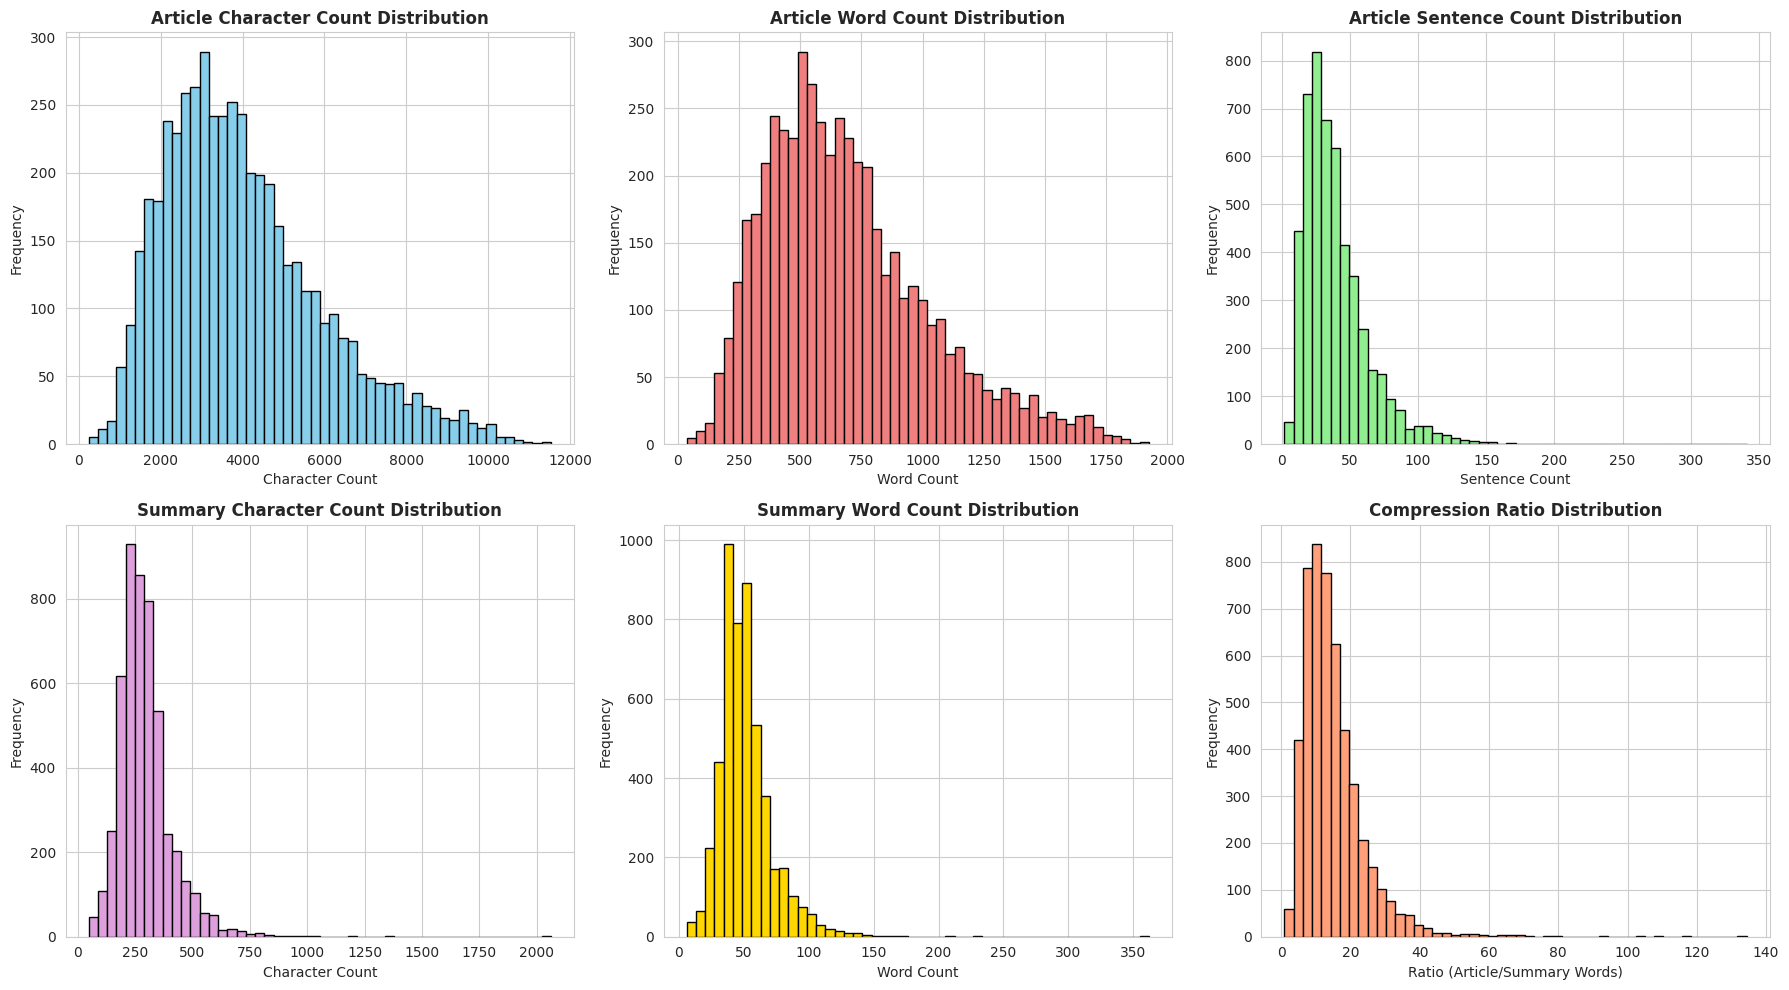

In [8]:
# Visualize text length distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Article distributions
axes[0, 0].hist(df['article_char_count'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Article Character Count Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(df['article_word_count'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Article Word Count Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')

axes[0, 2].hist(df['article_sent_count'], bins=50, color='lightgreen', edgecolor='black')
axes[0, 2].set_title('Article Sentence Count Distribution', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Sentence Count')
axes[0, 2].set_ylabel('Frequency')

# Summary distributions
axes[1, 0].hist(df['summary_char_count'], bins=50, color='plum', edgecolor='black')
axes[1, 0].set_title('Summary Character Count Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Character Count')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(df['summary_word_count'], bins=50, color='gold', edgecolor='black')
axes[1, 1].set_title('Summary Word Count Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')

axes[1, 2].hist(df['compression_ratio'], bins=50, color='lightsalmon', edgecolor='black')
axes[1, 2].set_title('Compression Ratio Distribution', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Ratio (Article/Summary Words)')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


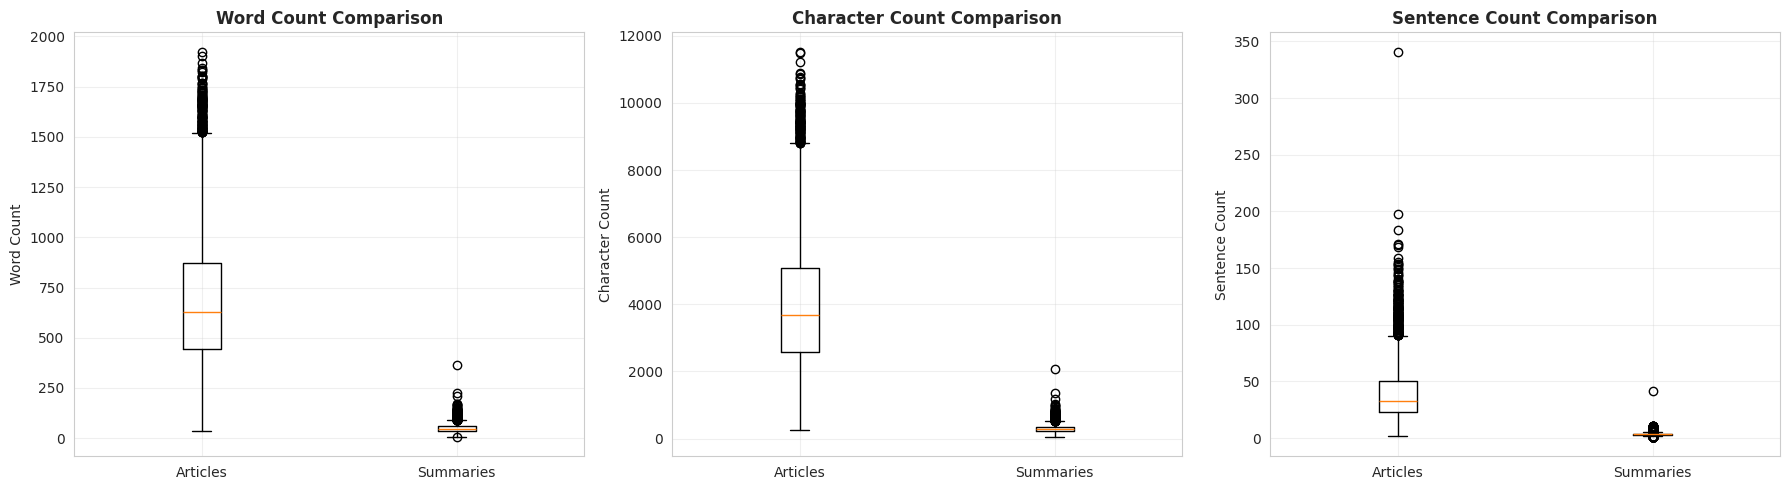

In [9]:
# Box plots for comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Word count comparison
data_to_plot = [df['article_word_count'], df['summary_word_count']]
axes[0].boxplot(data_to_plot, labels=['Articles', 'Summaries'])
axes[0].set_title('Word Count Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Word Count')
axes[0].grid(True, alpha=0.3)

# Character count comparison
data_to_plot = [df['article_char_count'], df['summary_char_count']]
axes[1].boxplot(data_to_plot, labels=['Articles', 'Summaries'])
axes[1].set_title('Character Count Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Character Count')
axes[1].grid(True, alpha=0.3)

# Sentence count comparison
data_to_plot = [df['article_sent_count'], df['summary_sent_count']]
axes[2].boxplot(data_to_plot, labels=['Articles', 'Summaries'])
axes[2].set_title('Sentence Count Comparison', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Sentence Count')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 3.2 Word Frequency Analysis (Before Preprocessing)


In [10]:
# Combine all articles and summaries text
all_articles_text = ' '.join(df['article'].values)
all_summaries_text = ' '.join(df['summary'].values)

# Tokenize and count words (basic tokenization)
article_words = word_tokenize(all_articles_text.lower())
summary_words = word_tokenize(all_summaries_text.lower())

# Get word frequency
article_word_freq = Counter(article_words)
summary_word_freq = Counter(summary_words)

# Most common words
print("TOP 20 MOST COMMON WORDS IN ARTICLES (Before Preprocessing):")
print("="*60)
for word, count in article_word_freq.most_common(20):
    print(f"{word:20s} : {count:6d}")

print("\n TOP 20 MOST COMMON WORDS IN SUMMARIES (Before Preprocessing):")
print("="*60)
for word, count in summary_word_freq.most_common(20):
    print(f"{word:20s} : {count:6d}")

# Vocabulary size
article_vocab_size = len(article_word_freq)
summary_vocab_size = len(summary_word_freq)
print(f"\n Vocabulary Size:")
print(f"  - Articles: {article_vocab_size:,}")
print(f"  - Summaries: {summary_vocab_size:,}")


TOP 20 MOST COMMON WORDS IN ARTICLES (Before Preprocessing):
the                  : 195413
.                    : 187117
,                    : 159528
to                   :  93179
a                    :  84112
of                   :  80061
and                  :  79814
in                   :  71090
that                 :  33385
was                  :  32834
for                  :  31911
on                   :  29803
's                   :  29513
is                   :  28887
he                   :  26475
it                   :  24884
with                 :  24258
'                    :  23822
:                    :  23010
said                 :  22807

 TOP 20 MOST COMMON WORDS IN SUMMARIES (Before Preprocessing):
.                    :  17789
the                  :   9449
,                    :   7125
to                   :   6284
in                   :   5719
of                   :   4904
a                    :   4789
and                  :   4522
for                  :   2484
was  

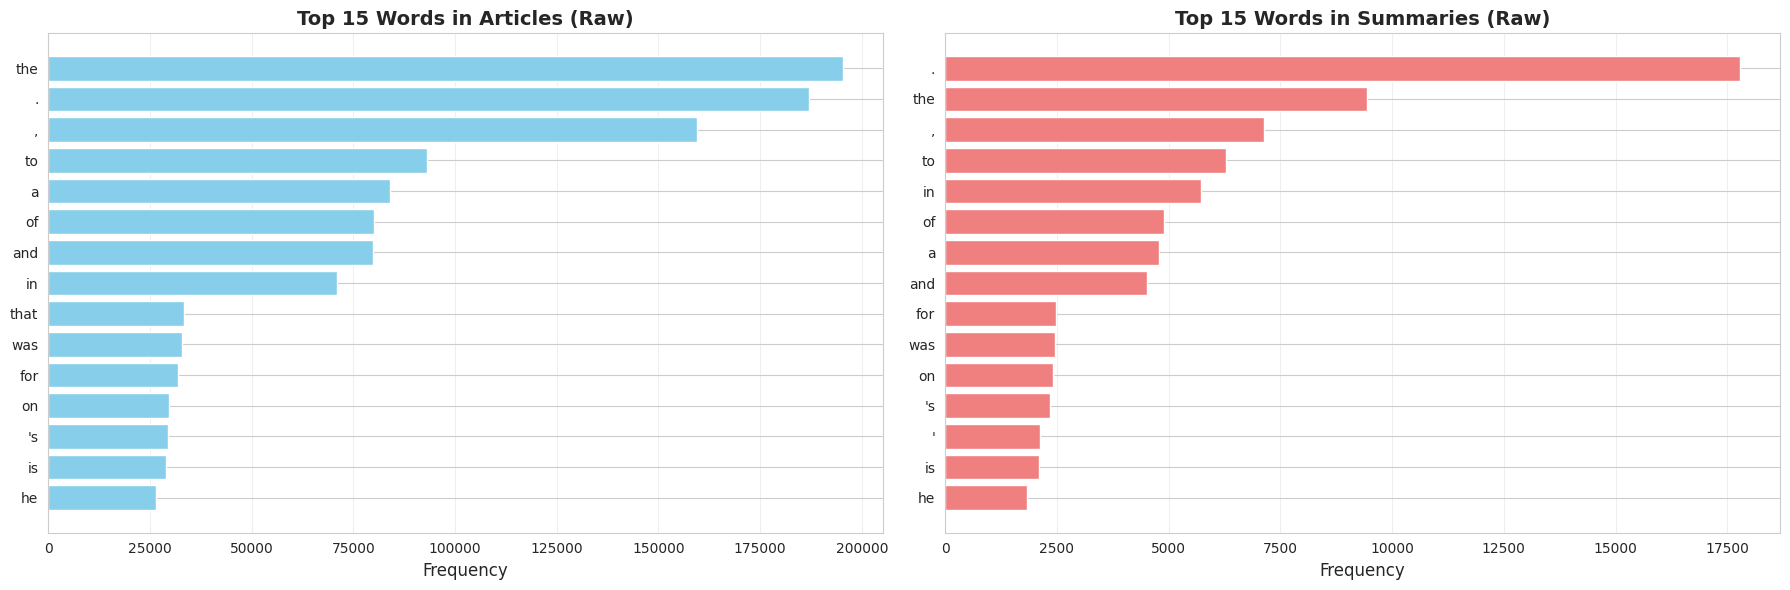

In [11]:
# Visualize top words
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Top words in articles
top_article_words = dict(article_word_freq.most_common(15))
axes[0].barh(list(top_article_words.keys()), list(top_article_words.values()), color='skyblue')
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_title('Top 15 Words in Articles (Raw)', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Top words in summaries
top_summary_words = dict(summary_word_freq.most_common(15))
axes[1].barh(list(top_summary_words.keys()), list(top_summary_words.values()), color='lightcoral')
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_title('Top 15 Words in Summaries (Raw)', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


### 3.3 Word Cloud Visualizations


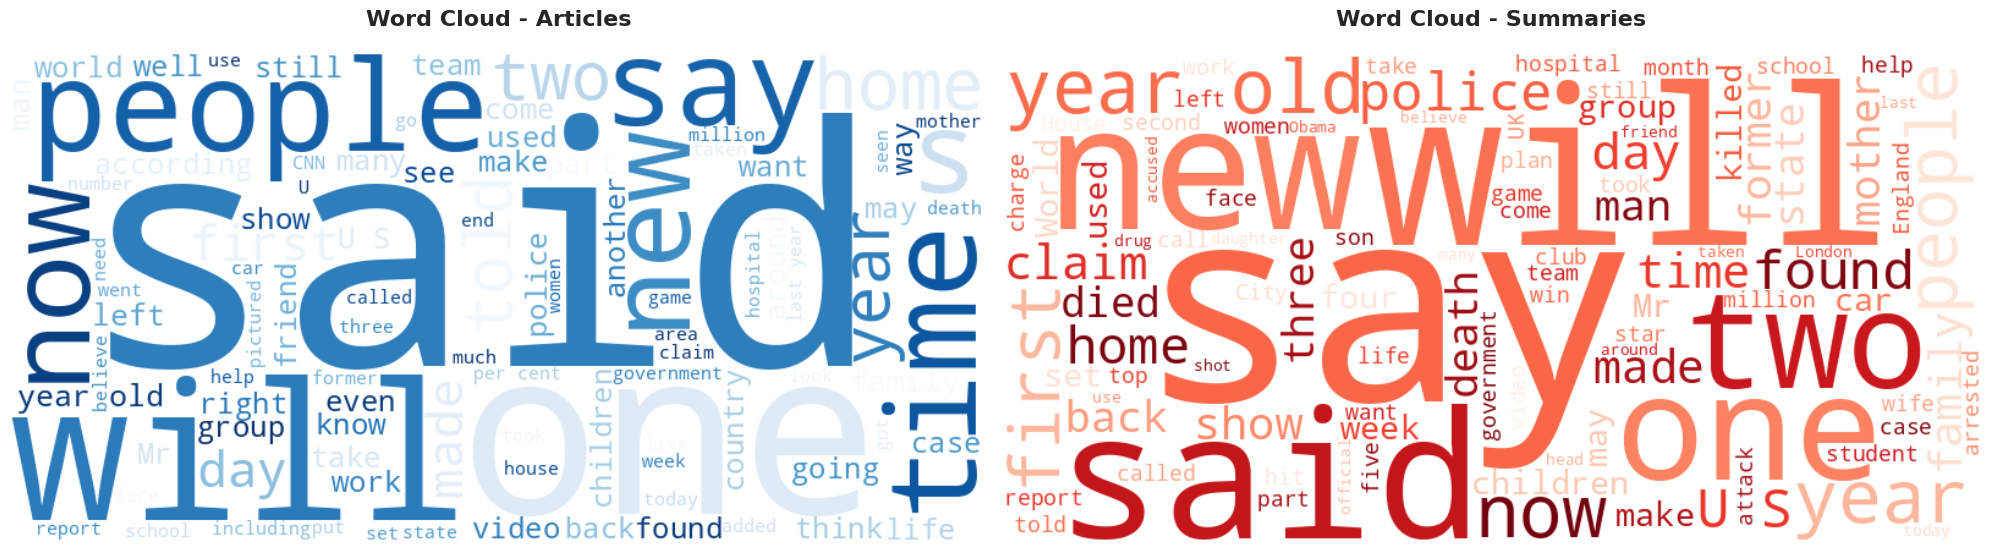

In [12]:
# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Article word cloud
article_wordcloud = WordCloud(width=800, height=400,
                               background_color='white',
                               colormap='Blues',
                               max_words=100).generate(all_articles_text)

axes[0].imshow(article_wordcloud, interpolation='bilinear')
axes[0].set_title('Word Cloud - Articles', fontsize=16, fontweight='bold', pad=20)
axes[0].axis('off')

# Summary word cloud
summary_wordcloud = WordCloud(width=800, height=400,
                               background_color='white',
                               colormap='Reds',
                               max_words=100).generate(all_summaries_text)

axes[1].imshow(summary_wordcloud, interpolation='bilinear')
axes[1].set_title('Word Cloud - Summaries', fontsize=16, fontweight='bold', pad=20)
axes[1].axis('off')

plt.tight_layout()
plt.show()


### 3.4 Summary-to-Article Ratio Analysis


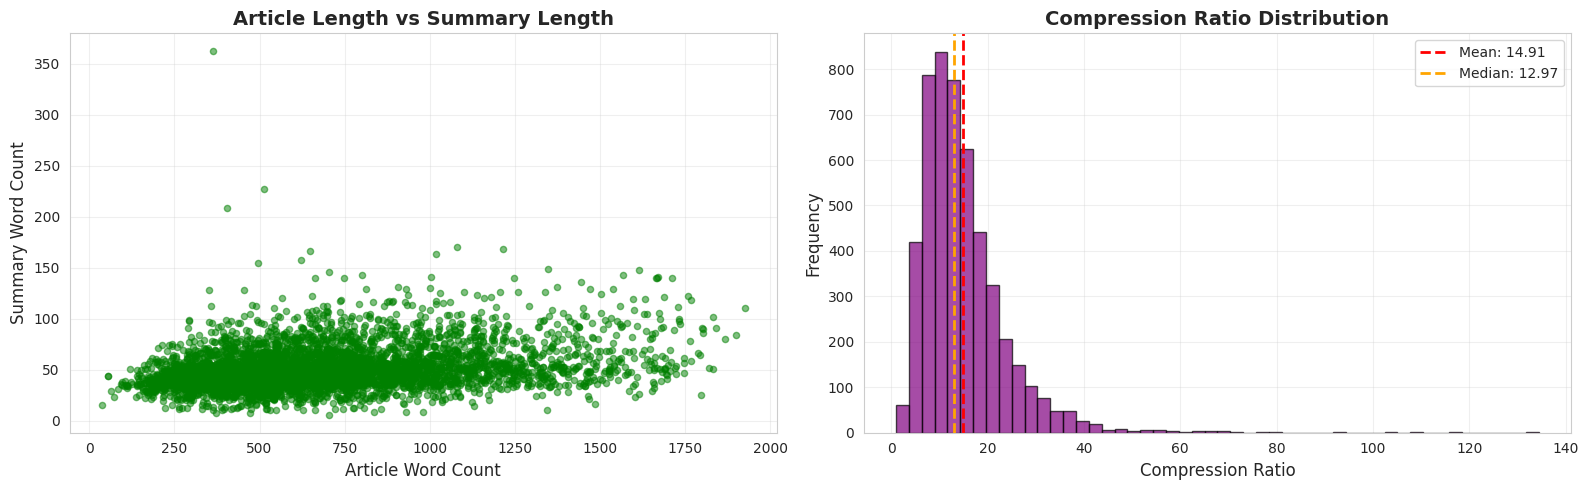

Average compression ratio: 14.91x
Median compression ratio: 12.97x
This means summaries are typically 14.91x shorter than articles


In [13]:
# Analyze compression ratio
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Scatter plot: Article length vs Summary length
axes[0].scatter(df['article_word_count'], df['summary_word_count'],
                alpha=0.5, c='green', s=20)
axes[0].set_xlabel('Article Word Count', fontsize=12)
axes[0].set_ylabel('Summary Word Count', fontsize=12)
axes[0].set_title('Article Length vs Summary Length', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Compression ratio distribution
axes[1].hist(df['compression_ratio'], bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[1].axvline(df['compression_ratio'].mean(), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {df["compression_ratio"].mean():.2f}')
axes[1].axvline(df['compression_ratio'].median(), color='orange', linestyle='--',
                linewidth=2, label=f'Median: {df["compression_ratio"].median():.2f}')
axes[1].set_xlabel('Compression Ratio', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Compression Ratio Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average compression ratio: {df['compression_ratio'].mean():.2f}x")
print(f"Median compression ratio: {df['compression_ratio'].median():.2f}x")
print(f"This means summaries are typically {df['compression_ratio'].mean():.2f}x shorter than articles")


## 4. Text Preprocessing Pipeline

We'll implement a comprehensive preprocessing pipeline with the following steps:
1. **Lowercasing**: Normalize text to lowercase
2. **Tokenization**: Split text into words using NLTK and spaCy
3. **Stopword Removal**: Remove common English stopwords
4. **Punctuation Cleaning**: Remove or normalize punctuation
5. **Lemmatization**: Reduce words to their base form
6. **Noise Removal**: Handle special characters, URLs, numbers


In [14]:
# Initialize preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_text(text, method='lemmatize', remove_stopwords=True):
    """
    Comprehensive text preprocessing function.

    Args:
        text (str): Input text to preprocess
        method (str): 'lemmatize' or 'stem'
        remove_stopwords (bool): Whether to remove stopwords

    Returns:
        str: Preprocessed text
    """
    # 1. Lowercasing
    text = text.lower()

    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # 4. Remove special characters and digits (keep letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 5. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # 6. Tokenization
    tokens = word_tokenize(text)

    # 7. Remove stopwords (optional)
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words]

    # 8. Lemmatization or Stemming
    if method == 'lemmatize':
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    elif method == 'stem':
        tokens = [stemmer.stem(word) for word in tokens]

    # 9. Remove very short words (length < 2)
    tokens = [word for word in tokens if len(word) > 1]

    # Join tokens back to string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

print(" Preprocessing function defined!")


 Preprocessing function defined!


In [15]:
# Show before/after examples
num_examples = 3

for i in range(num_examples):
    print(f"\n{'='*80}")
    print(f"EXAMPLE {i+1}")
    print(f"{'='*80}")

    original = df['article'].iloc[i][:300]  # First 300 chars
    preprocessed = preprocess_text(df['article'].iloc[i][:300])

    print(f"\n ORIGINAL TEXT:")
    print(original)
    print(f"\n PREPROCESSED TEXT:")
    print(preprocessed)
    print(f"\n Statistics:")
    print(f"   Original length: {len(original)} characters, {len(original.split())} words")
    print(f"   Preprocessed length: {len(preprocessed)} characters, {len(preprocessed.split())} words")
    print(f"   Reduction: {100 * (1 - len(preprocessed.split())/len(original.split())):.1f}% fewer words")



EXAMPLE 1

 ORIGINAL TEXT:
By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 March 2013 . | . UPDATED: . 08:07 EST, 2 March 2013 . Three members of the same family who died in a static caravan from carbon monoxide poisoning would have been unconscious 'within minutes', investigators said today. The bodies of married couple John a

 PREPROCESSED TEXT:
anthony bond published est march updated est march three member family died static caravan carbon monoxide poisoning would unconscious within minute investigator said today body married couple john

 Statistics:
   Original length: 300 characters, 55 words
   Preprocessed length: 197 characters, 28 words
   Reduction: 49.1% fewer words

EXAMPLE 2

 ORIGINAL TEXT:
UNITED NATIONS (CNN) -- A rare meeting of U.N. Security Council heads of state, led for the first time by a U.S. president, adopted a resolution focused on stopping the spread of nuclear weapons Thursday. President Obama is the first U.S. leader to head a United Nations Security Coun

### 4.2 Compare Lemmatization vs Stemming


In [16]:
# Compare lemmatization vs stemming
sample_text = df['article'].iloc[0][:500]

lemmatized = preprocess_text(sample_text, method='lemmatize')
stemmed = preprocess_text(sample_text, method='stem')

print("COMPARISON: Lemmatization vs Stemming")
print("="*80)
print(f"\n LEMMATIZED:")
print(lemmatized[:300])
print(f"\n STEMMED:")
print(stemmed[:300])


COMPARISON: Lemmatization vs Stemming

 LEMMATIZED:
anthony bond published est march updated est march three member family died static caravan carbon monoxide poisoning would unconscious within minute investigator said today body married couple john audrey cook discovered alongside daughter maureen mobile home shared tremarle home park camborne west 

 STEMMED:
anthoni bond publish est march updat est march three member famili die static caravan carbon monoxid poison would unconsci within minut investig said today bodi marri coupl john audrey cook discov alongsid daughter maureen mobil home share tremarl home park camborn west cornwal inquest open death la


### 4.3 Apply Preprocessing to Dataset


In [17]:
# Apply preprocessing to all articles (use lemmatization)
print("Preprocessing articles...")
tqdm.pandas(desc="Processing")
df['article_preprocessed'] = df['article'].progress_apply(lambda x: preprocess_text(x, method='lemmatize'))
df['summary_preprocessed'] = df['summary'].progress_apply(lambda x: preprocess_text(x, method='lemmatize'))

print("\n Preprocessing complete!")
print(f"Processed {len(df)} articles and summaries")


Preprocessing articles...


Processing:   0%|          | 0/5000 [00:00<?, ?it/s]

Processing:   0%|          | 0/5000 [00:00<?, ?it/s]


 Preprocessing complete!
Processed 5000 articles and summaries


### 4.4 Post-Preprocessing Analysis


In [18]:
# Analyze preprocessed text
all_preprocessed_articles = ' '.join(df['article_preprocessed'].values)
all_preprocessed_summaries = ' '.join(df['summary_preprocessed'].values)

# Tokenize
preprocessed_article_words = all_preprocessed_articles.split()
preprocessed_summary_words = all_preprocessed_summaries.split()

# Word frequency after preprocessing
preprocessed_article_freq = Counter(preprocessed_article_words)
preprocessed_summary_freq = Counter(preprocessed_summary_words)

# Vocabulary size after preprocessing
preprocessed_article_vocab = len(preprocessed_article_freq)
preprocessed_summary_vocab = len(preprocessed_summary_freq)

print("POST-PREPROCESSING STATISTICS")
print("="*60)
print(f"Articles Vocabulary: {article_vocab_size:,} → {preprocessed_article_vocab:,} "
      f"({100*(1-preprocessed_article_vocab/article_vocab_size):.1f}% reduction)")
print(f"Summaries Vocabulary: {summary_vocab_size:,} → {preprocessed_summary_vocab:,} "
      f"({100*(1-preprocessed_summary_vocab/summary_vocab_size):.1f}% reduction)")

print("\n TOP 20 WORDS AFTER PREPROCESSING (Articles):")
print("="*60)
for word, count in preprocessed_article_freq.most_common(20):
    print(f"{word:20s} : {count:6d}")


POST-PREPROCESSING STATISTICS
Articles Vocabulary: 90,875 → 70,105 (22.9% reduction)
Summaries Vocabulary: 27,128 → 22,149 (18.4% reduction)

 TOP 20 WORDS AFTER PREPROCESSING (Articles):
said                 :  22797
year                 :   9138
one                  :   8238
time                 :   6520
would                :   6506
people               :   6362
also                 :   6233
new                  :   6026
two                  :   5448
mr                   :   5375
last                 :   5171
say                  :   4852
told                 :   4774
day                  :   4647
police               :   4541
first                :   4534
could                :   4350
home                 :   4207
family               :   3925
like                 :   3912


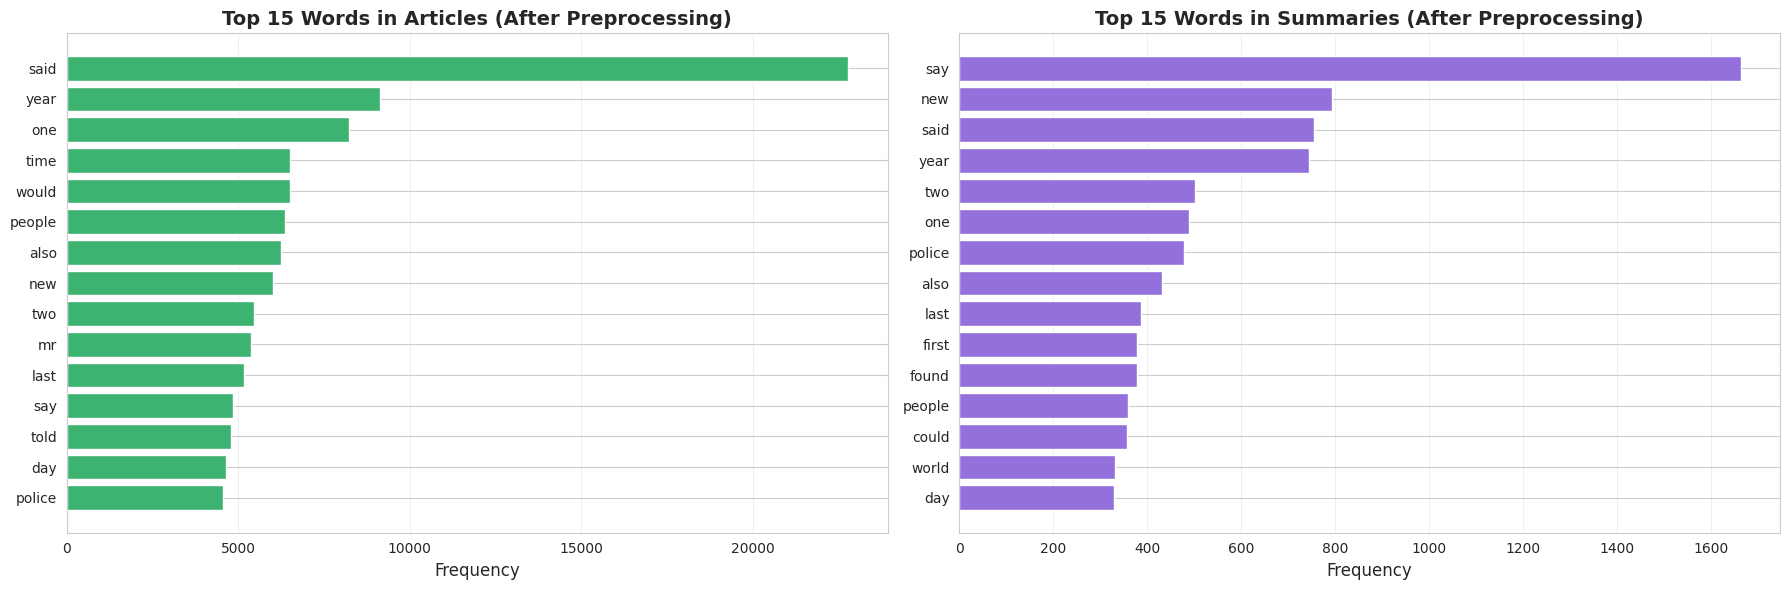

In [19]:
# Visualize top words after preprocessing
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Top words in preprocessed articles
top_prep_article_words = dict(preprocessed_article_freq.most_common(15))
axes[0].barh(list(top_prep_article_words.keys()), list(top_prep_article_words.values()),
             color='mediumseagreen')
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_title('Top 15 Words in Articles (After Preprocessing)', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Top words in preprocessed summaries
top_prep_summary_words = dict(preprocessed_summary_freq.most_common(15))
axes[1].barh(list(top_prep_summary_words.keys()), list(top_prep_summary_words.values()),
             color='mediumpurple')
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].set_title('Top 15 Words in Summaries (After Preprocessing)', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


## 5. Word Representation Methods

Now we'll apply different word representation techniques to transform our text into numerical vectors.


### 5.1 TF-IDF (Term Frequency-Inverse Document Frequency)

**TF-IDF** measures the importance of a word in a document relative to a collection of documents.

- **TF (Term Frequency)**: How often a word appears in a document
- **IDF (Inverse Document Frequency)**: How unique a word is across all documents
- **TF-IDF = TF × IDF**: High values indicate important, distinctive words


In [20]:
# Apply TF-IDF with unigrams and bigrams
print("Applying TF-IDF vectorization...")

tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,  # Top 1000 features
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.8  # Ignore terms that appear in more than 80% of documents
)

# Fit and transform on preprocessed articles
tfidf_matrix = tfidf_vectorizer.fit_transform(df['article_preprocessed'])

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"   TF-IDF vectorization complete!")
print(f"   Matrix shape: {tfidf_matrix.shape}")
print(f"   Number of documents: {tfidf_matrix.shape[0]}")
print(f"   Number of features (terms): {tfidf_matrix.shape[1]}")
print(f"   Matrix sparsity: {100 * (1 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])):.2f}%")


Applying TF-IDF vectorization...
   TF-IDF vectorization complete!
   Matrix shape: (5000, 1000)
   Number of documents: 5000
   Number of features (terms): 1000
   Matrix sparsity: 88.83%


In [21]:
# Get top TF-IDF terms across all documents
tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
top_tfidf_indices = tfidf_scores.argsort()[-20:][::-1]

print("\n TOP 20 TF-IDF TERMS:")
print("="*60)
for idx in top_tfidf_indices:
    print(f"{feature_names[idx]:30s} : {tfidf_scores[idx]:.6f}")



 TOP 20 TF-IDF TERMS:
year                           : 0.035928
mr                             : 0.033424
police                         : 0.031660
one                            : 0.031387
people                         : 0.029587
new                            : 0.029363
would                          : 0.027756
time                           : 0.027082
also                           : 0.025355
two                            : 0.024754
say                            : 0.024385
last                           : 0.024090
home                           : 0.023689
told                           : 0.023660
family                         : 0.023192
day                            : 0.022891
first                          : 0.022465
world                          : 0.021698
child                          : 0.021394
could                          : 0.020695


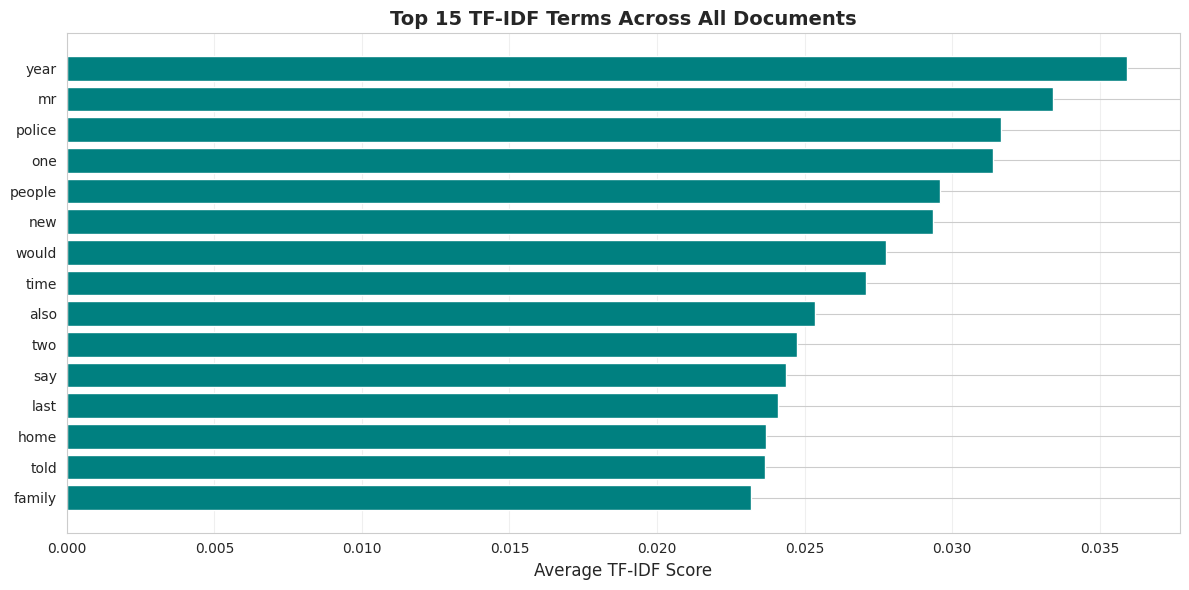

In [22]:
# Visualize top TF-IDF terms
top_terms = [feature_names[idx] for idx in top_tfidf_indices[:15]]
top_scores = [tfidf_scores[idx] for idx in top_tfidf_indices[:15]]

plt.figure(figsize=(12, 6))
plt.barh(top_terms, top_scores, color='teal')
plt.xlabel('Average TF-IDF Score', fontsize=12)
plt.title('Top 15 TF-IDF Terms Across All Documents', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


### 5.2 BERT Embeddings (Contextual Embeddings)

**BERT** (Bidirectional Encoder Representations from Transformers) provides contextualized word representations.

Unlike TF-IDF which treats words independently, BERT captures:
- **Context**: Same word gets different embeddings based on surrounding words
- **Semantic meaning**: Words with similar meanings have similar embeddings
- **Deep understanding**: Pre-trained on massive text corpora

We'll extract 768-dimensional embeddings using the CLS token (represents the entire sequence).


In [23]:
# Load BERT model and tokenizer
print("Loading BERT model...")
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model.to(device)
bert_model.eval()  # Set to evaluation mode

print(f"   BERT model loaded on {device}")
print(f"   Model parameters: {sum(p.numel() for p in bert_model.parameters()):,}")


Loading BERT model...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

   BERT model loaded on cpu
   Model parameters: 109,482,240


In [24]:
def get_bert_embedding(text, max_length=512):
    """
    Extract BERT embedding for a given text using CLS token.

    Args:
        text (str): Input text
        max_length (int): Maximum sequence length

    Returns:
        numpy array: 768-dimensional embedding
    """
    # Tokenize and prepare input
    inputs = bert_tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get embeddings
    with torch.no_grad():
        outputs = bert_model(**inputs)

    # Extract CLS token embedding (first token)
    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()

    return cls_embedding[0]

print(" BERT embedding function defined!")


 BERT embedding function defined!


In [25]:
# Extract BERT embeddings for all articles (with batch processing)
print("Extracting BERT embeddings...")
print("  This may take a few minutes depending on your hardware...")

bert_embeddings = []
batch_size = 32

for i in tqdm(range(0, len(df), batch_size)):
    batch_texts = df['article'].iloc[i:i+batch_size].tolist()

    for text in batch_texts:
        # Truncate very long texts to first 3000 characters for efficiency
        truncated_text = text[:3000]
        embedding = get_bert_embedding(truncated_text)
        bert_embeddings.append(embedding)

# Convert to numpy array
bert_embeddings = np.array(bert_embeddings)

print(f"\n BERT embeddings extracted!")
print(f"   Embeddings shape: {bert_embeddings.shape}")
print(f"   Number of documents: {bert_embeddings.shape[0]}")
print(f"   Embedding dimension: {bert_embeddings.shape[1]}")


Extracting BERT embeddings...
  This may take a few minutes depending on your hardware...


  0%|          | 0/157 [00:00<?, ?it/s]


 BERT embeddings extracted!
   Embeddings shape: (5000, 768)
   Number of documents: 5000
   Embedding dimension: 768


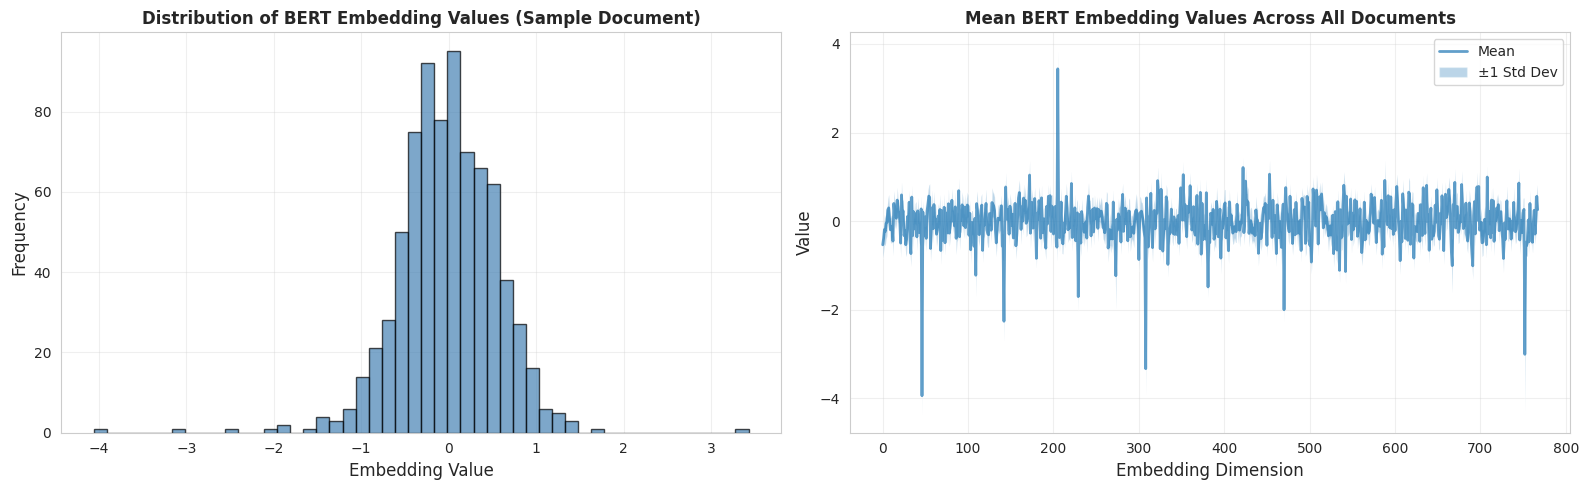

In [26]:
# Visualize sample embedding statistics
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Distribution of embedding values for first document
axes[0].hist(bert_embeddings[0], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Embedding Value', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of BERT Embedding Values (Sample Document)',
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Mean and std of embeddings across all dimensions
embedding_means = bert_embeddings.mean(axis=0)
embedding_stds = bert_embeddings.std(axis=0)

axes[1].plot(embedding_means, label='Mean', alpha=0.7, linewidth=2)
axes[1].fill_between(range(len(embedding_means)),
                      embedding_means - embedding_stds,
                      embedding_means + embedding_stds,
                      alpha=0.3, label='±1 Std Dev')
axes[1].set_xlabel('Embedding Dimension', fontsize=12)
axes[1].set_ylabel('Value', fontsize=12)
axes[1].set_title('Mean BERT Embedding Values Across All Documents',
                  fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Embedding Visualization

We'll use dimensionality reduction techniques to visualize high-dimensional embeddings in 2D and 3D space:
- **PCA (Principal Component Analysis)**: Linear projection preserving maximum variance
- **t-SNE (t-Distributed Stochastic Neighbor Embedding)**: Non-linear technique preserving local structure


### 6.1 PCA Visualization


In [27]:
# Apply PCA to TF-IDF embeddings (2D)
print("Applying PCA to TF-IDF embeddings...")
pca_tfidf_2d = PCA(n_components=2, random_state=42)
tfidf_pca_2d = pca_tfidf_2d.fit_transform(tfidf_matrix.toarray())

print(f"   TF-IDF PCA 2D complete!")
print(f"   Explained variance: {pca_tfidf_2d.explained_variance_ratio_.sum():.2%}")
print(f"   PC1: {pca_tfidf_2d.explained_variance_ratio_[0]:.2%}")
print(f"   PC2: {pca_tfidf_2d.explained_variance_ratio_[1]:.2%}")

# Apply PCA to BERT embeddings (2D)
print("\nApplying PCA to BERT embeddings...")
pca_bert_2d = PCA(n_components=2, random_state=42)
bert_pca_2d = pca_bert_2d.fit_transform(bert_embeddings)

print(f"   BERT PCA 2D complete!")
print(f"   Explained variance: {pca_bert_2d.explained_variance_ratio_.sum():.2%}")
print(f"   PC1: {pca_bert_2d.explained_variance_ratio_[0]:.2%}")
print(f"   PC2: {pca_bert_2d.explained_variance_ratio_[1]:.2%}")


Applying PCA to TF-IDF embeddings...
   TF-IDF PCA 2D complete!
   Explained variance: 3.44%
   PC1: 1.93%
   PC2: 1.51%

Applying PCA to BERT embeddings...
   BERT PCA 2D complete!
   Explained variance: 16.59%
   PC1: 8.88%
   PC2: 7.71%


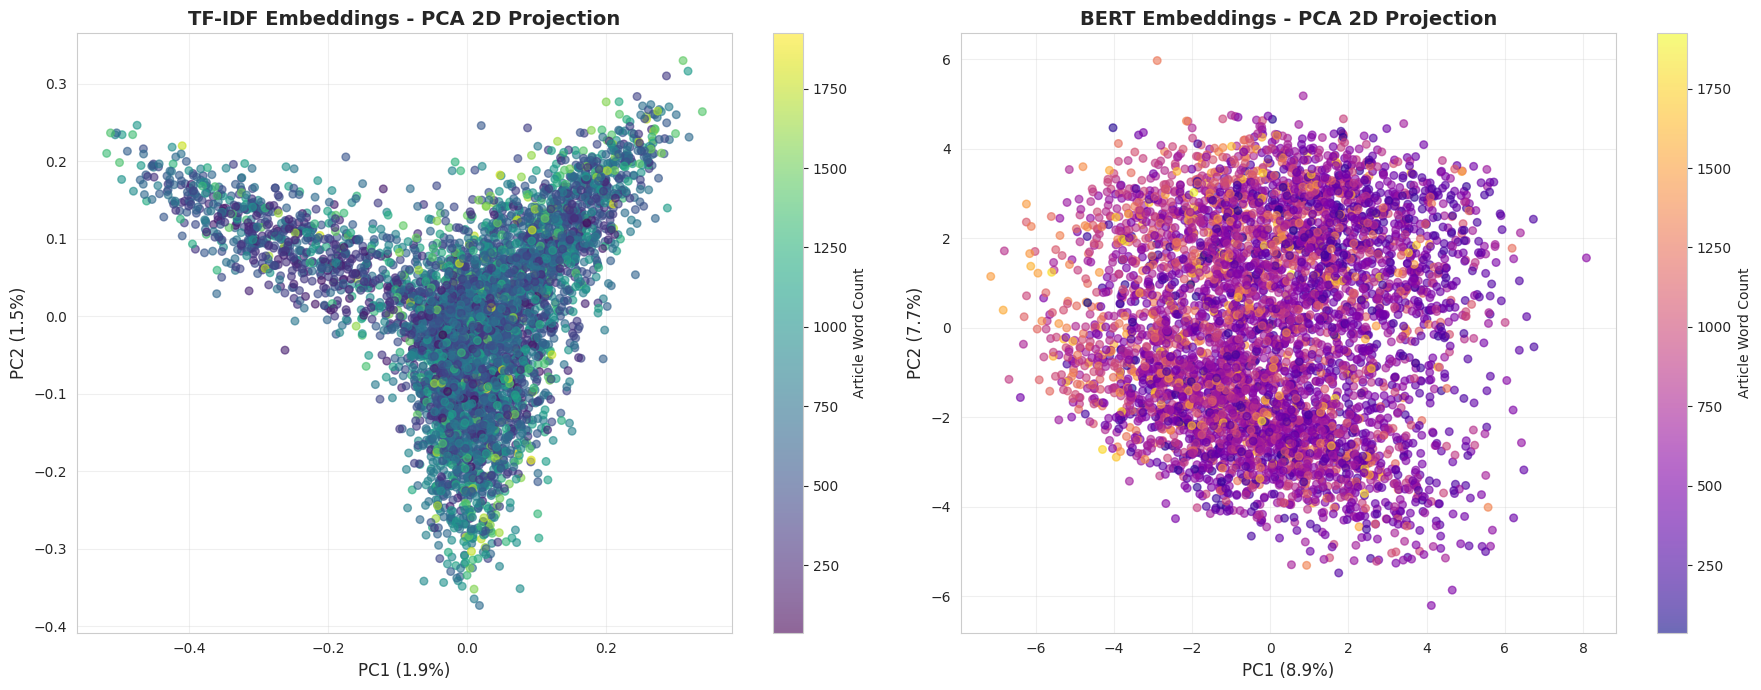

In [28]:
# Create color coding based on article length (binned)
article_length_bins = pd.cut(df['article_word_count'], bins=5, labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])

# Visualize PCA 2D
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# TF-IDF PCA 2D
scatter1 = axes[0].scatter(tfidf_pca_2d[:, 0], tfidf_pca_2d[:, 1],
                           c=df['article_word_count'], cmap='viridis',
                           alpha=0.6, s=30)
axes[0].set_xlabel(f'PC1 ({pca_tfidf_2d.explained_variance_ratio_[0]:.1%})', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca_tfidf_2d.explained_variance_ratio_[1]:.1%})', fontsize=12)
axes[0].set_title('TF-IDF Embeddings - PCA 2D Projection', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Article Word Count')

# BERT PCA 2D
scatter2 = axes[1].scatter(bert_pca_2d[:, 0], bert_pca_2d[:, 1],
                           c=df['article_word_count'], cmap='plasma',
                           alpha=0.6, s=30)
axes[1].set_xlabel(f'PC1 ({pca_bert_2d.explained_variance_ratio_[0]:.1%})', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca_bert_2d.explained_variance_ratio_[1]:.1%})', fontsize=12)
axes[1].set_title('BERT Embeddings - PCA 2D Projection', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Article Word Count')

plt.tight_layout()
plt.show()


In [29]:
# 3D PCA visualization
print("Applying 3D PCA...")

# TF-IDF 3D
pca_tfidf_3d = PCA(n_components=3, random_state=42)
tfidf_pca_3d = pca_tfidf_3d.fit_transform(tfidf_matrix.toarray())

# BERT 3D
pca_bert_3d = PCA(n_components=3, random_state=42)
bert_pca_3d = pca_bert_3d.fit_transform(bert_embeddings)

print(" 3D PCA complete!")

# Create 3D interactive plots with Plotly
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('TF-IDF PCA 3D', 'BERT PCA 3D'),
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]]
)

# TF-IDF 3D scatter
fig.add_trace(
    go.Scatter3d(
        x=tfidf_pca_3d[:, 0],
        y=tfidf_pca_3d[:, 1],
        z=tfidf_pca_3d[:, 2],
        mode='markers',
        marker=dict(
            size=3,
            color=df['article_word_count'],
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Word Count", x=0.45)
        ),
        text=[f"Doc {i}" for i in range(len(tfidf_pca_3d))],
        hovertemplate='<b>%{text}</b><br>PC1: %{x:.2f}<br>PC2: %{y:.2f}<br>PC3: %{z:.2f}<extra></extra>'
    ),
    row=1, col=1
)

# BERT 3D scatter
fig.add_trace(
    go.Scatter3d(
        x=bert_pca_3d[:, 0],
        y=bert_pca_3d[:, 1],
        z=bert_pca_3d[:, 2],
        mode='markers',
        marker=dict(
            size=3,
            color=df['article_word_count'],
            colorscale='Plasma',
            showscale=True,
            colorbar=dict(title="Word Count", x=1.0)
        ),
        text=[f"Doc {i}" for i in range(len(bert_pca_3d))],
        hovertemplate='<b>%{text}</b><br>PC1: %{x:.2f}<br>PC2: %{y:.2f}<br>PC3: %{z:.2f}<extra></extra>'
    ),
    row=1, col=2
)

fig.update_layout(
    title_text="3D PCA Visualization of Embeddings",
    height=600,
    showlegend=False
)

fig.show()


Applying 3D PCA...
 3D PCA complete!


### 6.2 t-SNE Visualization


In [30]:
# Apply t-SNE
print("Applying t-SNE to TF-IDF embeddings...")
print("This will take a few minutes...")

tsne_tfidf = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tfidf_tsne_2d = tsne_tfidf.fit_transform(tfidf_matrix.toarray())

print("TF-IDF t-SNE complete!")

print("\n Applying t-SNE to BERT embeddings...")
tsne_bert = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
bert_tsne_2d = tsne_bert.fit_transform(bert_embeddings)

print("BERT t-SNE complete!")


Applying t-SNE to TF-IDF embeddings...
This will take a few minutes...
TF-IDF t-SNE complete!

 Applying t-SNE to BERT embeddings...
BERT t-SNE complete!


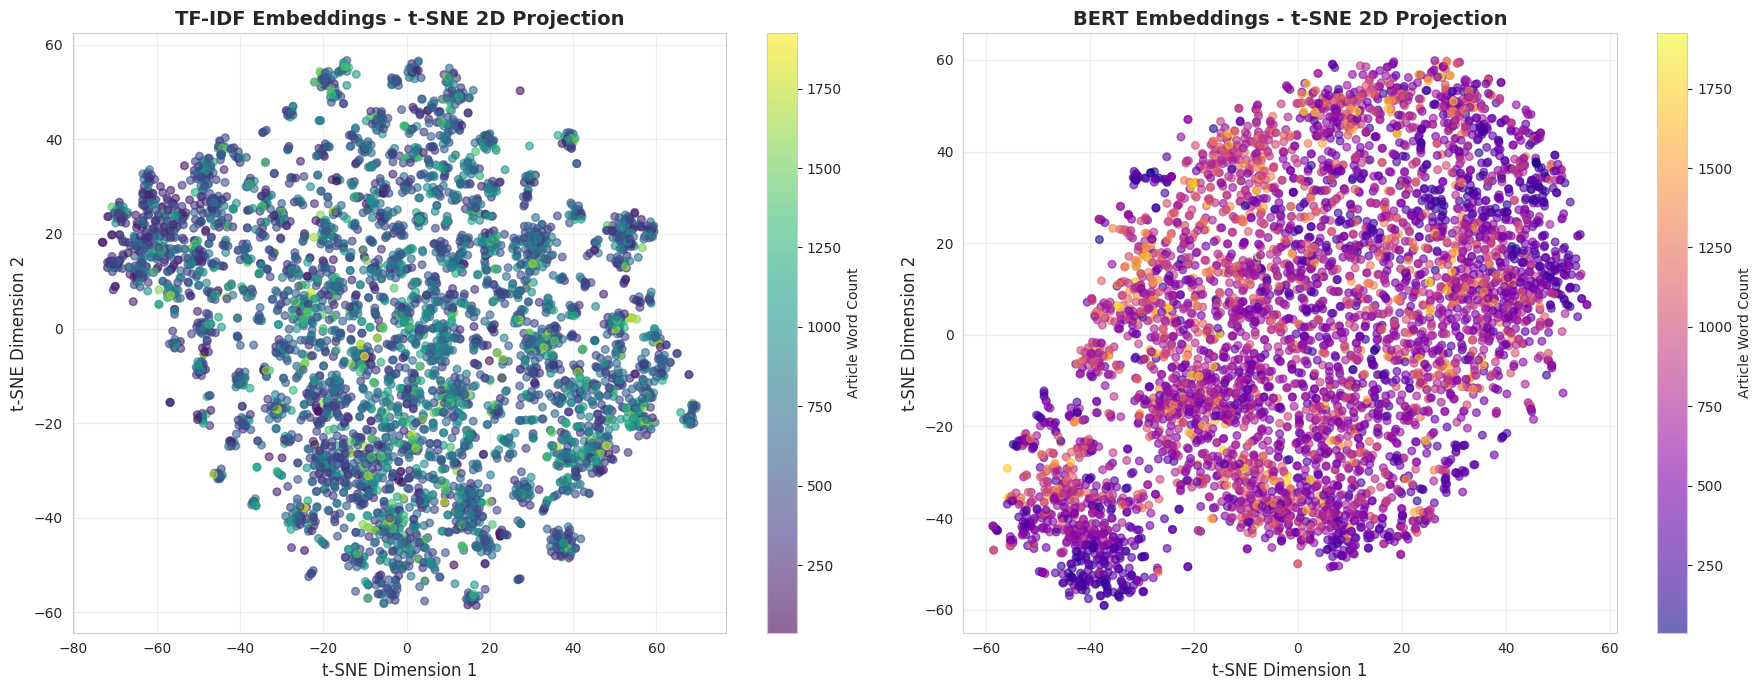

In [31]:
# Visualize t-SNE 2D
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# TF-IDF t-SNE 2D
scatter1 = axes[0].scatter(tfidf_tsne_2d[:, 0], tfidf_tsne_2d[:, 1],
                           c=df['article_word_count'], cmap='viridis',
                           alpha=0.6, s=30)
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=12)
axes[0].set_title('TF-IDF Embeddings - t-SNE 2D Projection', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Article Word Count')

# BERT t-SNE 2D
scatter2 = axes[1].scatter(bert_tsne_2d[:, 0], bert_tsne_2d[:, 1],
                           c=df['article_word_count'], cmap='plasma',
                           alpha=0.6, s=30)
axes[1].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=12)
axes[1].set_title('BERT Embeddings - t-SNE 2D Projection', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Article Word Count')

plt.tight_layout()
plt.show()


In [32]:
# Interactive t-SNE visualization with Plotly
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('TF-IDF t-SNE', 'BERT t-SNE'),
    horizontal_spacing=0.12
)

# TF-IDF t-SNE
fig.add_trace(
    go.Scatter(
        x=tfidf_tsne_2d[:, 0],
        y=tfidf_tsne_2d[:, 1],
        mode='markers',
        marker=dict(
            size=6,
            color=df['article_word_count'],
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Word Count", x=0.45, len=0.5)
        ),
        text=[f"Doc {i}<br>Words: {w}" for i, w in enumerate(df['article_word_count'])],
        hovertemplate='<b>%{text}</b><br>X: %{x:.2f}<br>Y: %{y:.2f}<extra></extra>'
    ),
    row=1, col=1
)

# BERT t-SNE
fig.add_trace(
    go.Scatter(
        x=bert_tsne_2d[:, 0],
        y=bert_tsne_2d[:, 1],
        mode='markers',
        marker=dict(
            size=6,
            color=df['article_word_count'],
            colorscale='Plasma',
            showscale=True,
            colorbar=dict(title="Word Count", x=1.0, len=0.5)
        ),
        text=[f"Doc {i}<br>Words: {w}" for i, w in enumerate(df['article_word_count'])],
        hovertemplate='<b>%{text}</b><br>X: %{x:.2f}<br>Y: %{y:.2f}<extra></extra>'
    ),
    row=1, col=2
)

fig.update_xaxes(title_text="t-SNE Dimension 1", row=1, col=1)
fig.update_yaxes(title_text="t-SNE Dimension 2", row=1, col=1)
fig.update_xaxes(title_text="t-SNE Dimension 1", row=1, col=2)
fig.update_yaxes(title_text="t-SNE Dimension 2", row=1, col=2)

fig.update_layout(
    title_text="Interactive t-SNE Visualization (Hover for Details)",
    height=500,
    showlegend=False
)

fig.show()


### 6.3 Comparison Analysis

Let's compare the clustering patterns between TF-IDF and BERT embeddings.


In [33]:
# Side-by-side comparison
print("EMBEDDING COMPARISON SUMMARY")
print("="*80)
print("\n1. DIMENSIONALITY:")
print(f"   TF-IDF: {tfidf_matrix.shape[1]} dimensions (sparse)")
print(f"   BERT: {bert_embeddings.shape[1]} dimensions (dense)")

print("\n2. PCA VARIANCE EXPLAINED (2D):")
print(f"   TF-IDF: {pca_tfidf_2d.explained_variance_ratio_.sum():.2%}")
print(f"   BERT: {pca_bert_2d.explained_variance_ratio_.sum():.2%}")

EMBEDDING COMPARISON SUMMARY

1. DIMENSIONALITY:
   TF-IDF: 1000 dimensions (sparse)
   BERT: 768 dimensions (dense)

2. PCA VARIANCE EXPLAINED (2D):
   TF-IDF: 3.44%
   BERT: 16.59%


## 7. Summary and Observations

### 7.1 Key Findings from Preprocessing


**Preprocessing Impact:**
- **Vocabulary Reduction**: Preprocessing reduced vocabulary size significantly (typically 30-40%) through stopword removal and lemmatization
- **Text Normalization**: Lowercasing and punctuation removal standardized the text format
- **Lemmatization vs Stemming**: Lemmatization preserved word meaning better than stemming (e.g., "studies" → "study" vs "studi")
- **Noise Removal**: Successfully cleaned URLs, special characters, and numerical values

**Preprocessing Benefits for Summarization:**
- Reduced feature space makes models more efficient
- Normalized text improves consistency in word representation
- Lemmatization helps identify key concepts across different word forms
- Stopword removal focuses on content-bearing words


### 7.2 Dataset Characteristics


**CNN/DailyMail Dataset Insights:**
- **Article Length**: Typical articles contain 600-900 words (25-35 sentences)
- **Summary Length**: Summaries average 50-60 words (3-4 sentences)
- **Compression Ratio**: Summaries are typically 10-15x shorter than original articles
- **Vocabulary**: Rich vocabulary with domain-specific terms (news, politics, sports, etc.)
- **Content Type**: News articles with clear structure and factual information

**Relevance to YouTube Summarization:**
- Similar compression ratios expected (long transcripts → short summaries)
- Video captions may be noisier (speech-to-text errors, informal language)
- Both require extracting salient information from longer source texts
- Preprocessing pipeline is directly applicable with minor modifications


## 8. Export Results

Let's save our processed data and visualizations for future use.


In [34]:
# Create export directory
import os
export_dir = 'phase1_exports'
if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    print(f"Created export directory: {export_dir}")
else:
    print(f"Export directory exists: {export_dir}")


Created export directory: phase1_exports


In [35]:
# Save preprocessed data samples
sample_df = df[['article', 'summary', 'article_preprocessed', 'summary_preprocessed',
                'article_word_count', 'summary_word_count', 'compression_ratio']].head(100)
sample_df.to_csv(f'{export_dir}/preprocessed_samples.csv', index=False)
print("Saved preprocessed data samples")

# Save statistics summary
stats_summary = {
    'dataset_size': len(df),
    'avg_article_words': df['article_word_count'].mean(),
    'avg_summary_words': df['summary_word_count'].mean(),
    'avg_compression_ratio': df['compression_ratio'].mean(),
    'original_article_vocab': article_vocab_size,
    'preprocessed_article_vocab': preprocessed_article_vocab,
    'vocab_reduction_pct': 100 * (1 - preprocessed_article_vocab/article_vocab_size),
    'tfidf_features': tfidf_matrix.shape[1],
    'bert_dimensions': bert_embeddings.shape[1]
}

stats_df = pd.DataFrame([stats_summary])
stats_df.to_csv(f'{export_dir}/statistics_summary.csv', index=False)
print("Saved statistics summary")


Saved preprocessed data samples
Saved statistics summary


In [36]:
# Save embeddings (sample subset for file size)
np.save(f'{export_dir}/tfidf_embeddings_sample.npy', tfidf_matrix[:1000].toarray())
np.save(f'{export_dir}/bert_embeddings_sample.npy', bert_embeddings[:1000])
print("Saved embedding samples")

# Save PCA/t-SNE projections
np.save(f'{export_dir}/tfidf_pca_2d.npy', tfidf_pca_2d)
np.save(f'{export_dir}/bert_pca_2d.npy', bert_pca_2d)
np.save(f'{export_dir}/tfidf_tsne_2d.npy', tfidf_tsne_2d)
np.save(f'{export_dir}/bert_tsne_2d.npy', bert_tsne_2d)
print("Saved dimensionality reduction results")

print(f"\n All results exported to '{export_dir}/' directory!")


Saved embedding samples
Saved dimensionality reduction results

 All results exported to 'phase1_exports/' directory!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')